# Uber Car Supply

![](https://miro.medium.com/v2/resize:fit:1280/format:webp/1*J6twtRRNj8M9Mdq6c-KWxQ.jpeg)
![](https://bloximages.chicago2.vip.townnews.com/qctimes.com/content/tncms/assets/v3/editorial/1/bf/1bfebfe5-9951-554e-8b37-94d8b966040f/613274af029b3.image.jpg?resize=243%2C500)

## Case Understanding

Uber is a very famous and reliable transportation company, nevertheless has it ever happened to you that there were no cars available or that your ride was cancelled ? It's very annoying as a customer but Uber must be just as annoyed. Rightly so, it is money that doesn't go into its pocket and, worse, that could potentially go into the pockets of its competitors. 

## Motivation

The aim of this analysis is to identify the cause of cancellation and non-availability of cars and recommend ways to improve the situation. 

## Data

You can download the dataset [here](https://drive.google.com/uc?export=download&id=1rDrNmc2F9-1BCdTLXs4Eey05nCBBfZ1c)

## Importing Libraries, Reading and Understanding the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime



In [2]:
uber_data = pd.read_csv('Uber Request Data.csv')

In [3]:
# Checking the shape of the dataset
print("Dataset shape:", uber_data.shape)

Dataset shape: (6745, 6)


In [4]:
# Identifying duplicate records based on 'Request id'
duplicate_count = sum(uber_data.duplicated(subset="Request id"))
print(f"Duplicates found: {duplicate_count}")

Duplicates found: 0


In [5]:
# Percentage of missing values in each column
missing_percentage = uber_data.isnull().mean().round(4) * 100
print("Percentage of missing values:\n", missing_percentage.sort_values(ascending=False))


Percentage of missing values:
 Drop timestamp       58.03
Driver id            39.29
Request id            0.00
Pickup point          0.00
Status                0.00
Request timestamp     0.00
dtype: float64


Majority of missing values are in 'Drop timestamp' and 'Driver id', mainly due to canceled or unfulfilled requests.

In [6]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


## Data Formating

In [7]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


The data is not consistent (timestamp on at least 2 different formats). Let's make it uniform.

In [8]:
# Uniformity in date formats for 'Request timestamp'
uber_data['Request timestamp'] = uber_data['Request timestamp'].str.replace('/', '-')

# Handling missing seconds by adding ':00' where necessary
uber_data['Request timestamp'] = uber_data['Request timestamp'].apply(lambda x: str(x)+':00' if x.count(':') == 1 else x)

# Standardizing to datetime format
uber_data['Request timestamp'] = pd.to_datetime(uber_data['Request timestamp'], format="%d-%m-%Y %H:%M:%S")


In [9]:
# Formatting 'Drop timestamp' similarly
uber_data['Drop timestamp'] = uber_data['Drop timestamp'].str.replace('/', '-')
uber_data['Drop timestamp'] = pd.to_datetime(uber_data['Drop timestamp'], format="%d-%m-%Y %H:%M:%S", errors='coerce')

In [10]:
uber_data.head

<bound method NDFrame.head of       Request id Pickup point  Driver id             Status  \
0            619      Airport        1.0     Trip Completed   
1            867      Airport        1.0     Trip Completed   
2           1807         City        1.0     Trip Completed   
3           2532      Airport        1.0     Trip Completed   
4           3112         City        1.0     Trip Completed   
...          ...          ...        ...                ...   
6740        6745         City        NaN  No Cars Available   
6741        6752      Airport        NaN  No Cars Available   
6742        6751         City        NaN  No Cars Available   
6743        6754         City        NaN  No Cars Available   
6744        6753      Airport        NaN  No Cars Available   

       Request timestamp      Drop timestamp  
0    2016-07-11 11:51:00                 NaT  
1    2016-07-11 17:57:00                 NaT  
2    2016-07-12 09:17:00                 NaT  
3    2016-07-12 21:08:00 

That's better ! 

## Data Extraction

In [11]:
# Extracting the hour and day from 'Request timestamp'
uber_data['Request hour'] = uber_data['Request timestamp'].dt.hour
uber_data['Request day'] = uber_data['Request timestamp'].dt.day

In [12]:
uber_data.head

<bound method NDFrame.head of       Request id Pickup point  Driver id             Status  \
0            619      Airport        1.0     Trip Completed   
1            867      Airport        1.0     Trip Completed   
2           1807         City        1.0     Trip Completed   
3           2532      Airport        1.0     Trip Completed   
4           3112         City        1.0     Trip Completed   
...          ...          ...        ...                ...   
6740        6745         City        NaN  No Cars Available   
6741        6752      Airport        NaN  No Cars Available   
6742        6751         City        NaN  No Cars Available   
6743        6754         City        NaN  No Cars Available   
6744        6753      Airport        NaN  No Cars Available   

       Request timestamp      Drop timestamp  Request hour  Request day  
0    2016-07-11 11:51:00                 NaT            11           11  
1    2016-07-11 17:57:00                 NaT            17       

## Data Cleaning

In [13]:
# Dropping unnecessary columns for analysis
uber_data_cleaned = uber_data.drop(columns=['Drop timestamp', 'Request timestamp', 'Driver id', 'Request id'])


## Data Segmentation

In [14]:
# Segmenting data based on status and pickup point
completed_trips = uber_data_cleaned[uber_data_cleaned['Status'] == 'Trip Completed']
cancelled_trips = uber_data_cleaned[uber_data_cleaned['Status'] == 'Cancelled']
no_car_trips = uber_data_cleaned[uber_data_cleaned['Status'] == 'No Cars Available']

# Further segmentation by Pickup Point
cancelled_airport = cancelled_trips[cancelled_trips['Pickup point'] == 'Airport']
cancelled_city = cancelled_trips[cancelled_trips['Pickup point'] == 'City']

no_car_airport = no_car_trips[no_car_trips['Pickup point'] == 'Airport']
no_car_city = no_car_trips[no_car_trips['Pickup point'] == 'City']

completed_airport = completed_trips[completed_trips['Pickup point'] == 'Airport']
completed_city = completed_trips[completed_trips['Pickup point'] == 'City']


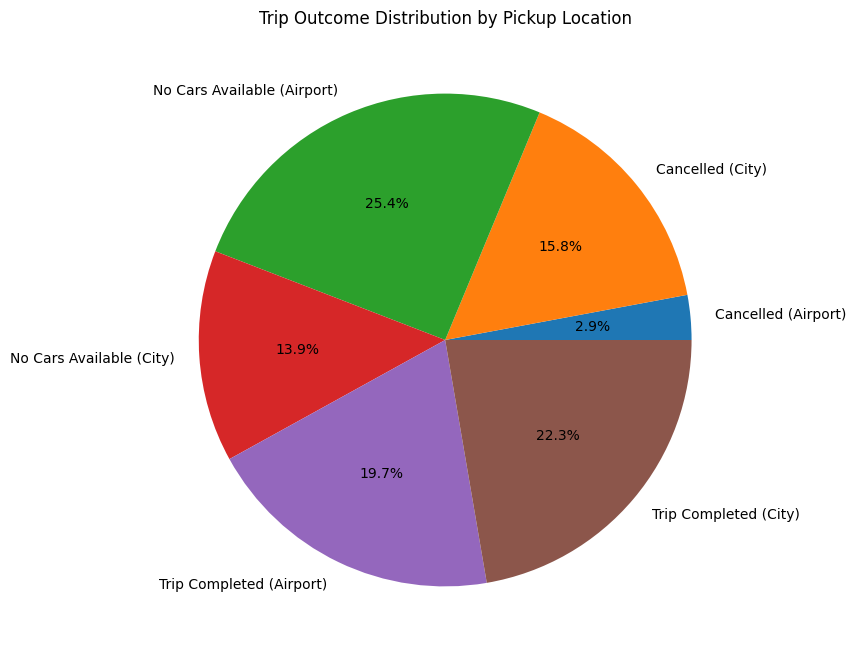

In [15]:

# Counts of different trip outcomes
trip_counts = [len(cancelled_airport), len(cancelled_city), len(no_car_airport), len(no_car_city), 
               len(completed_airport), len(completed_city)]

status_labels = ['Cancelled (Airport)', 'Cancelled (City)', 'No Cars Available (Airport)', 
                 'No Cars Available (City)', 'Trip Completed (Airport)', 'Trip Completed (City)']

# Visualizing the distribution of trip outcomes
plt.figure(figsize=(8, 8))
plt.pie(trip_counts, labels=status_labels, autopct='%1.1f%%')
plt.title('Trip Outcome Distribution by Pickup Location')
plt.show()


## Data Visualization

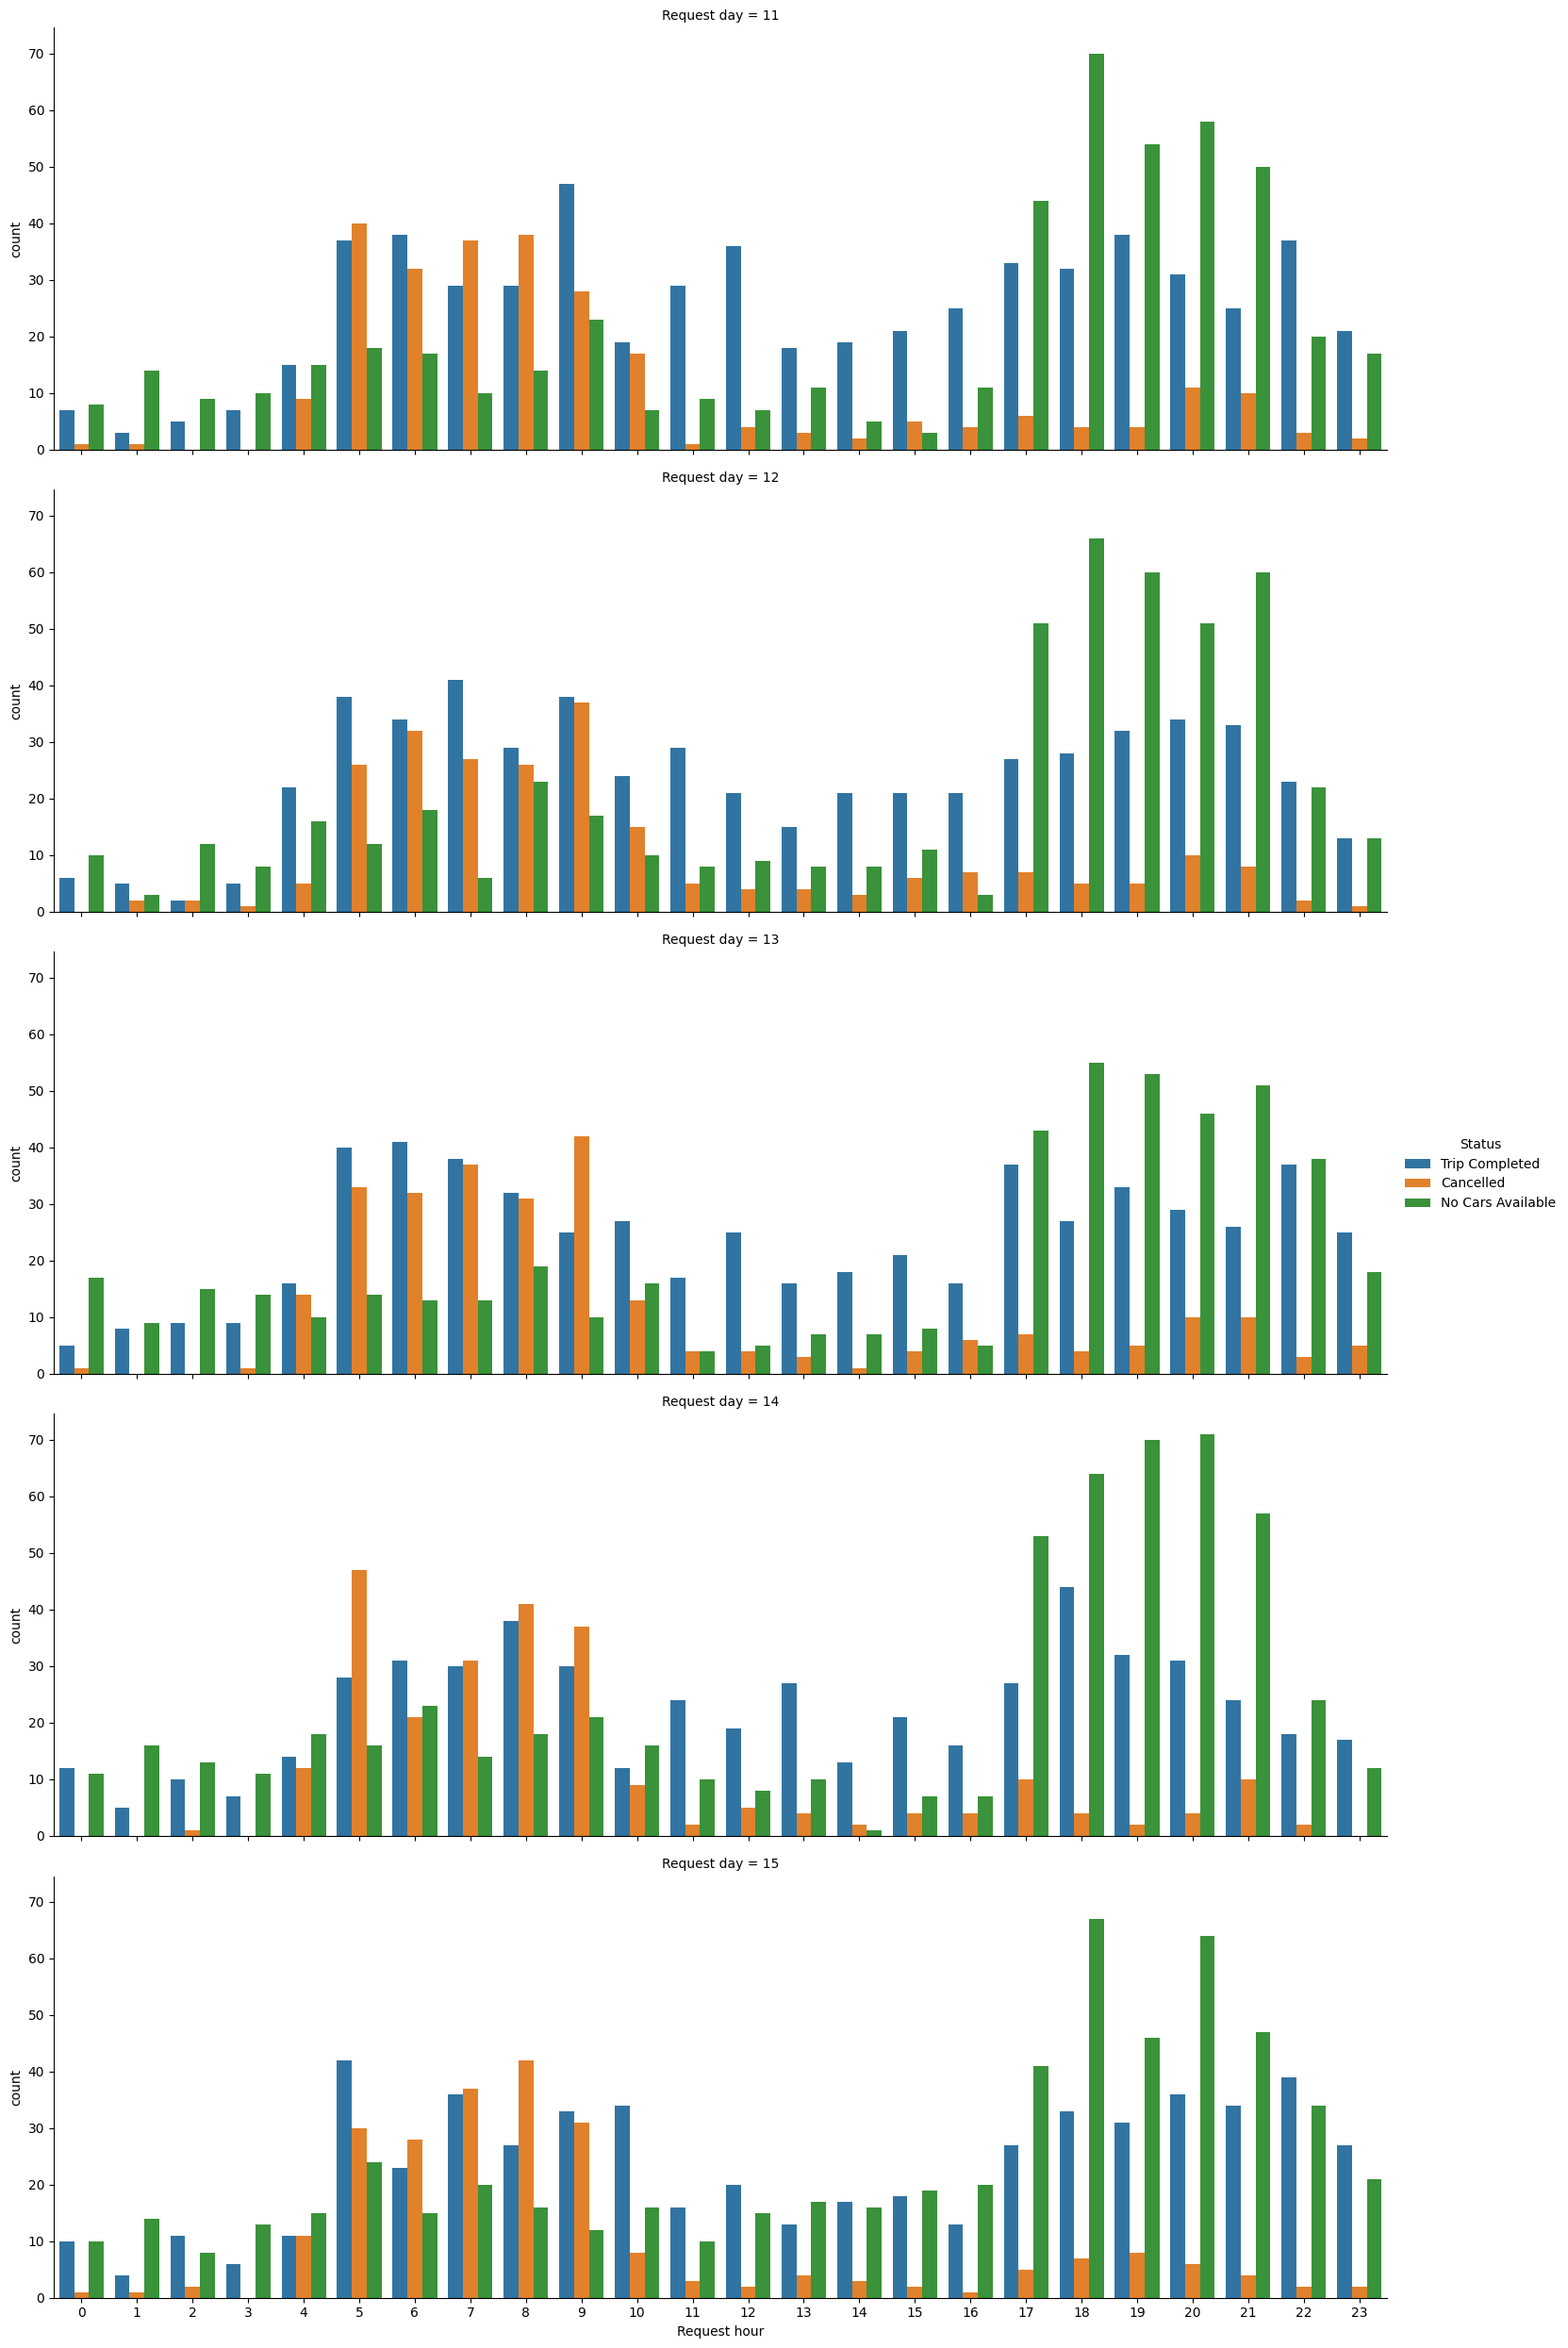

In [16]:
# Analyzing trip statuses based on hour and day
sns.catplot(x='Request hour', hue='Status', row='Request day', data=uber_data_cleaned, kind='count', aspect=3)
plt.show()

We can see a pattern with the green and orange columns 

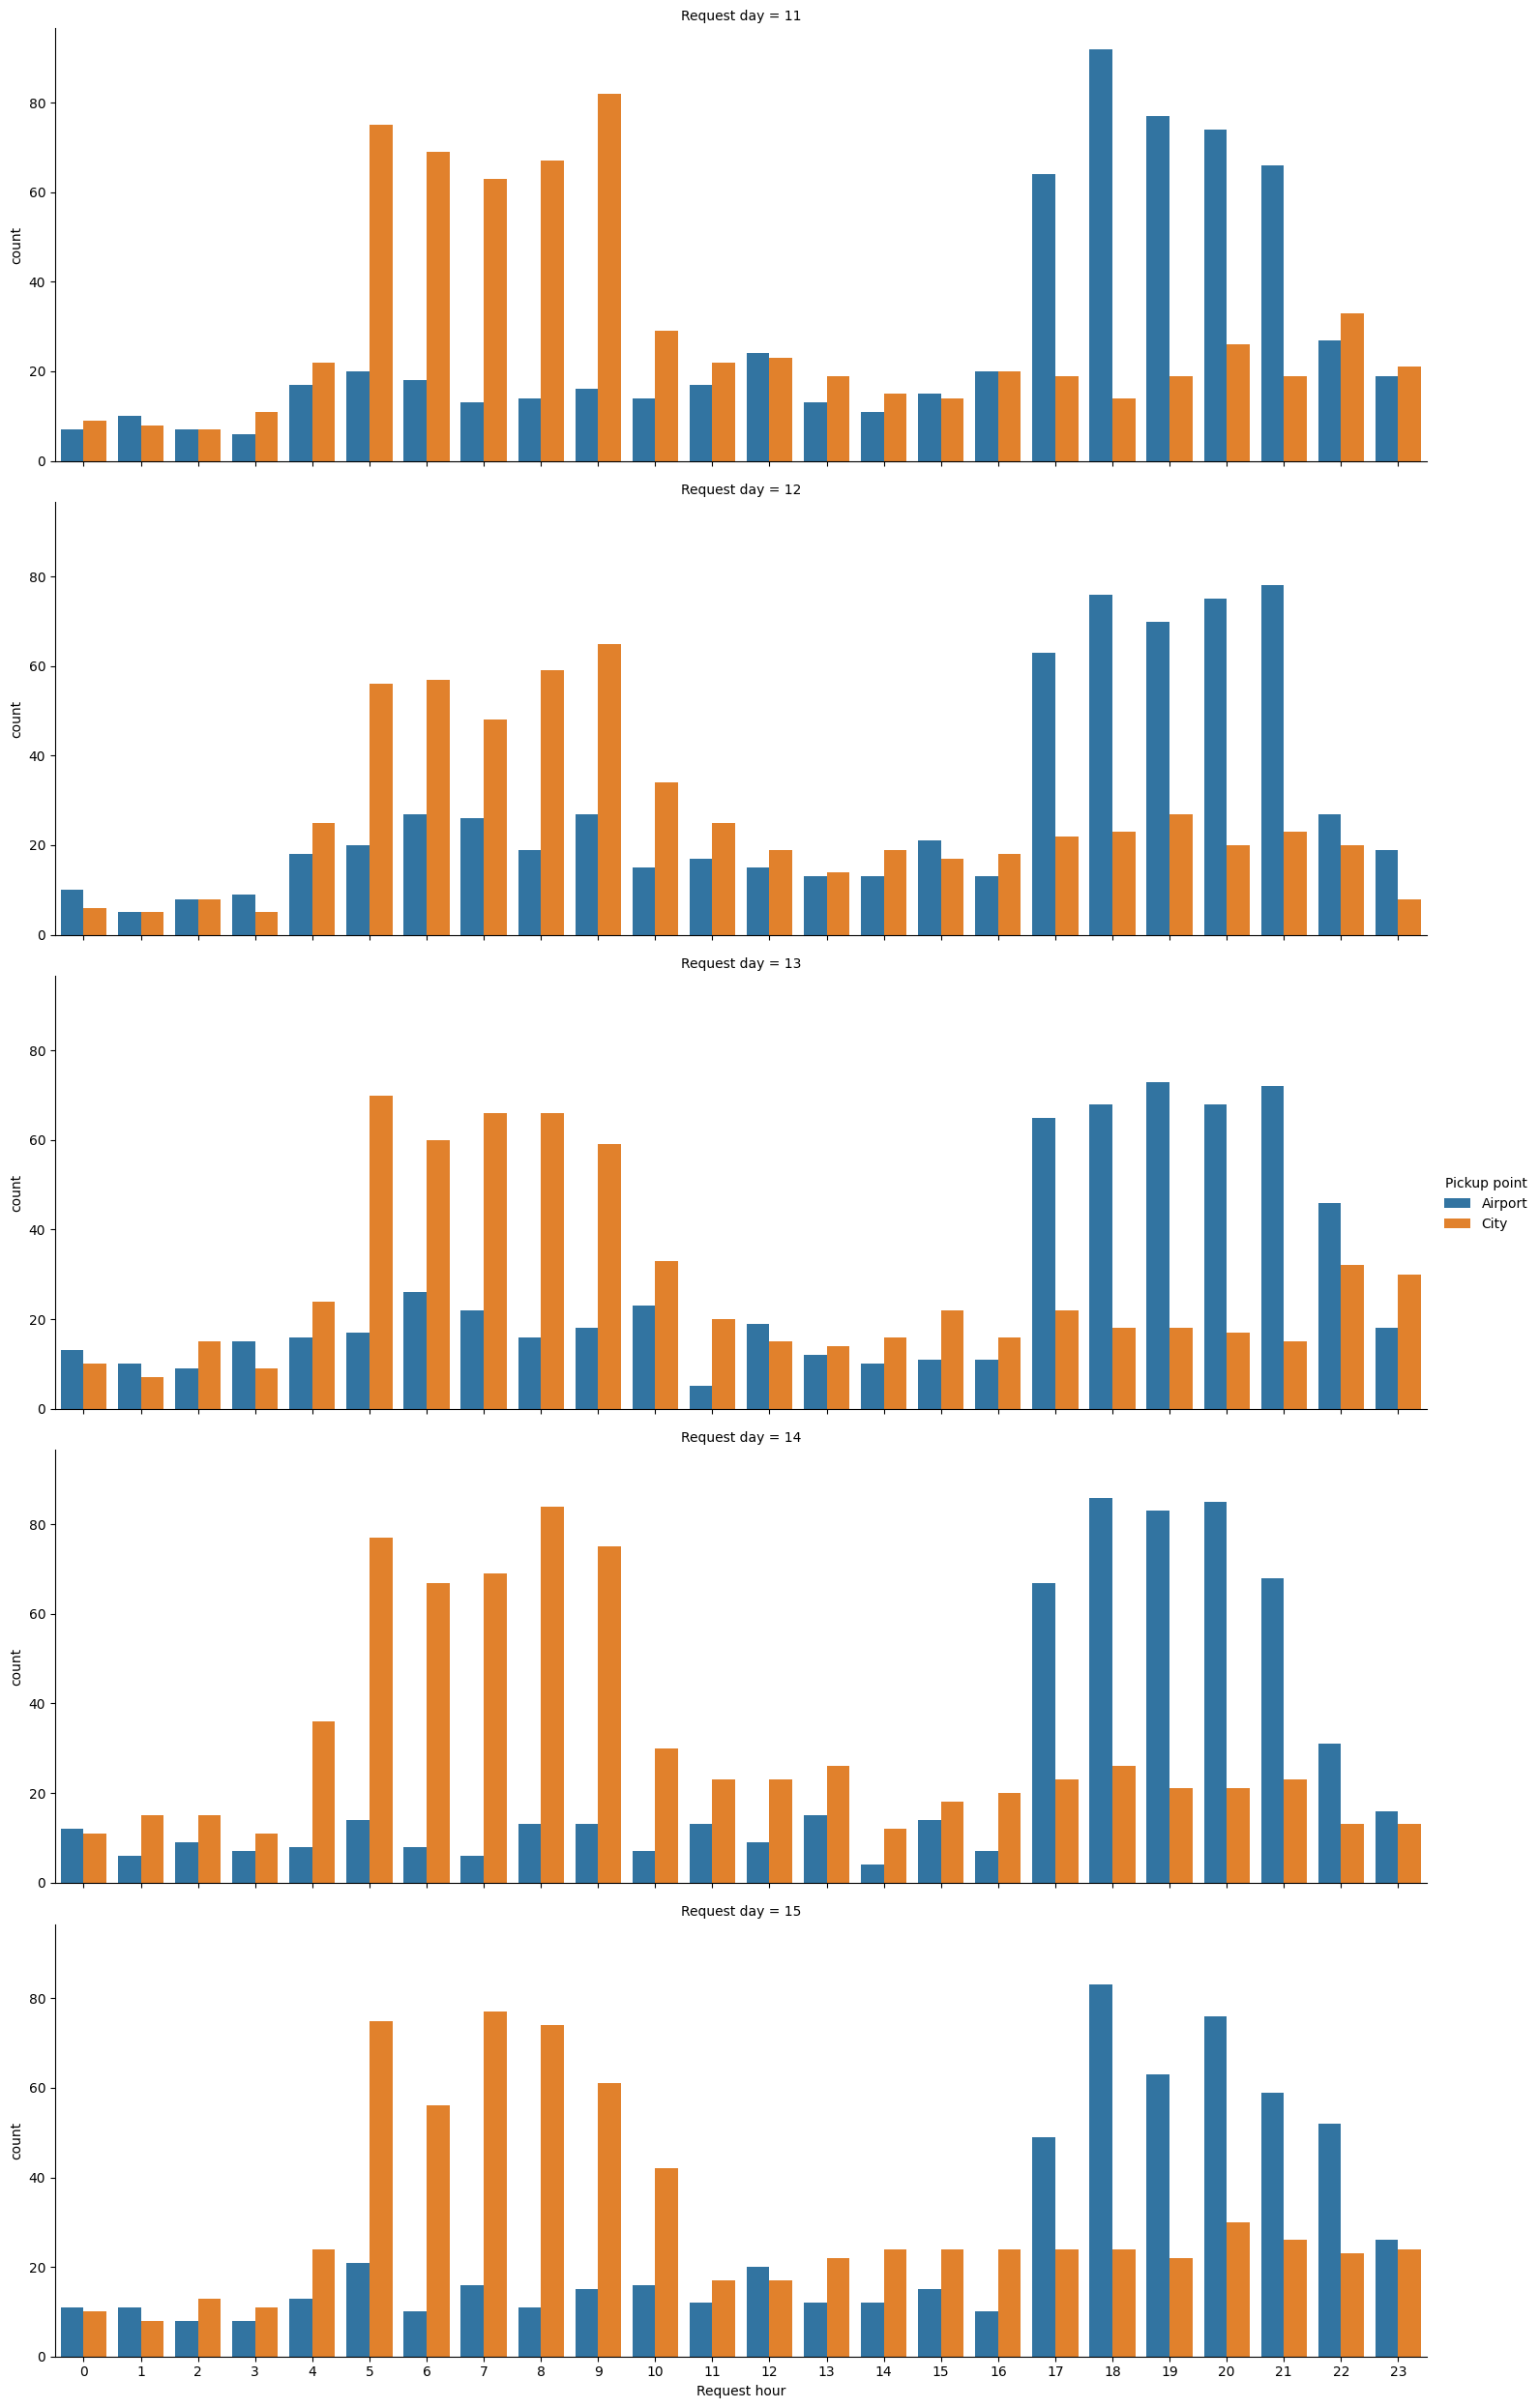

In [17]:
# Analyzing pickup points with request hour and day
sns.catplot(x='Request hour', hue='Pickup point', row='Request day', data=uber_data_cleaned, kind='count', aspect=3)
plt.show()

Here is also a pattern coming from the orange and blue columns 

In [18]:
# Creating time slots based on the hour of request
time_bins = [0, 5, 10, 17, 22, 24]
time_labels = ['Early Morning', 'Morning Rush', 'Daytime', 'Evening Rush', 'Late Night']
uber_data_cleaned['Time slot'] = pd.cut(uber_data_cleaned['Request hour'], bins=time_bins, labels=time_labels)


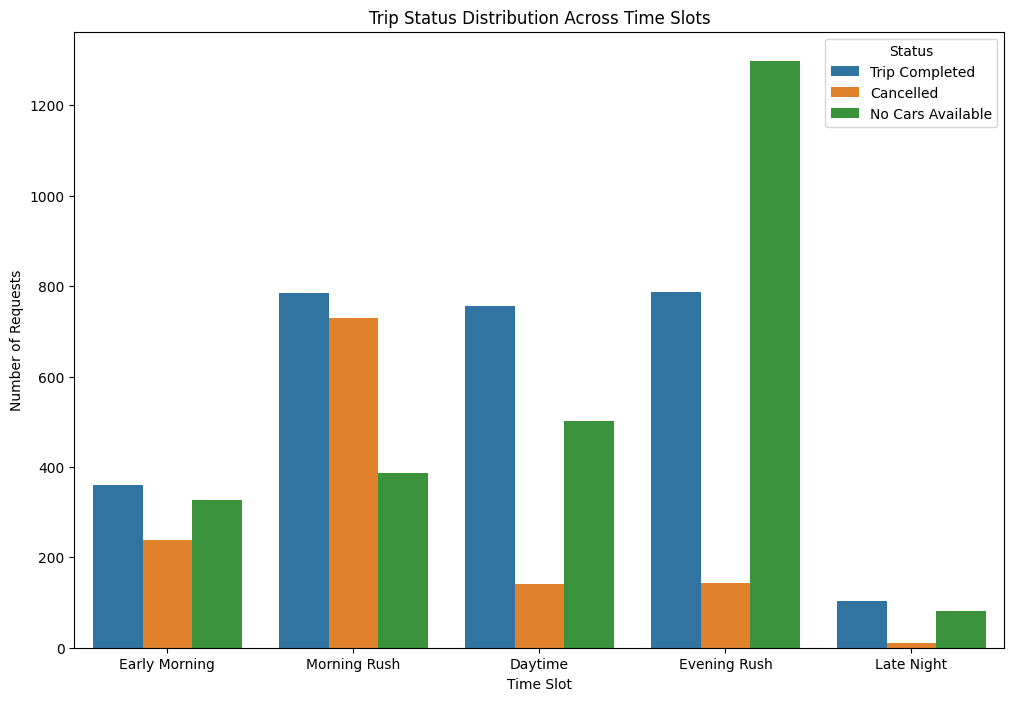

In [19]:
# Visualizing the status distribution across different time slots
plt.figure(figsize=(12, 8))
sns.countplot(x='Time slot', hue='Status', data=uber_data_cleaned)
plt.xlabel("Time Slot")
plt.ylabel("Number of Requests")
plt.title("Trip Status Distribution Across Time Slots")
plt.show()

#### Inteerpretation:
- Cars not available situation arises mostly in evening hours (from 5PM to 10PM).
- Most of the Cancellation happens in morning hours (from 5AM to 10AM).


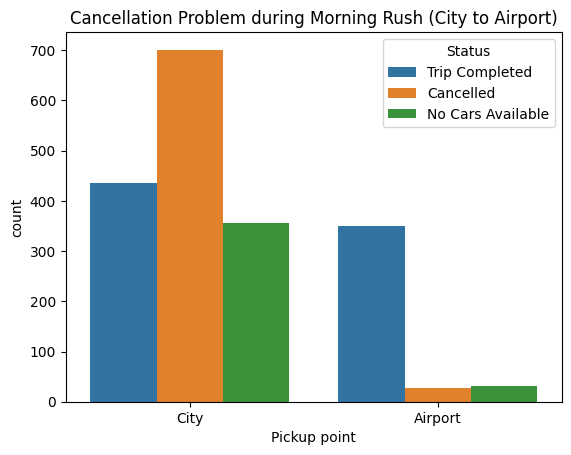

In [20]:
# Morning rush cancellation analysis
morning_rush_data = uber_data_cleaned[uber_data_cleaned['Time slot'] == 'Morning Rush']
sns.countplot(x='Pickup point', hue='Status', data=morning_rush_data)
plt.title("Cancellation Problem during Morning Rush (City to Airport)")
plt.show()

#### Interpretation:
- The Cancellation situation is a problem for the trip from City to airport in  morning hours.

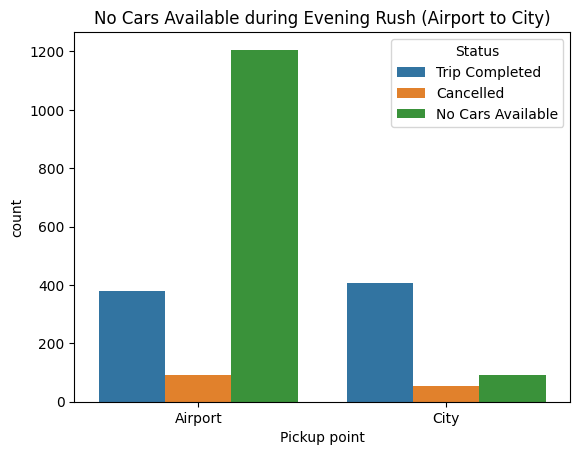

In [21]:
# Evening rush 'No cars available' analysis
evening_rush_data = uber_data_cleaned[uber_data_cleaned['Time slot'] == 'Evening Rush']
sns.countplot(x='Pickup point', hue='Status', data=evening_rush_data)
plt.title("No Cars Available during Evening Rush (Airport to City)")
plt.show()

#### Interpretation:
- The No cars available situation is a problem for the trip from airport to city in evening hours.

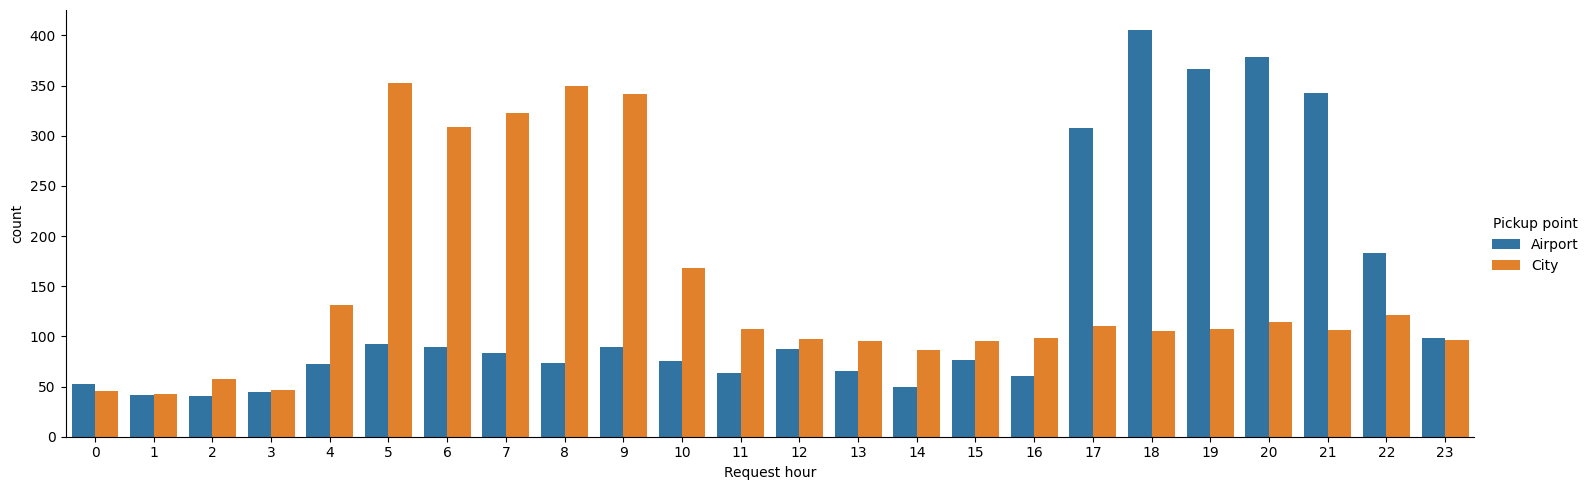

In [22]:
sns.catplot(x = 'Request hour', hue = 'Pickup point', data = uber_data, kind = 'count', aspect=3)

#### Interpretation:
- Most of the pickups encountered at daytime is from city suggesting more people travel to the airport in day hours.
- The pickups from Airport at evening hours are more and it suggests most people land in evening hours. 

# Additional Plots for EDA

### Cancelled Requests

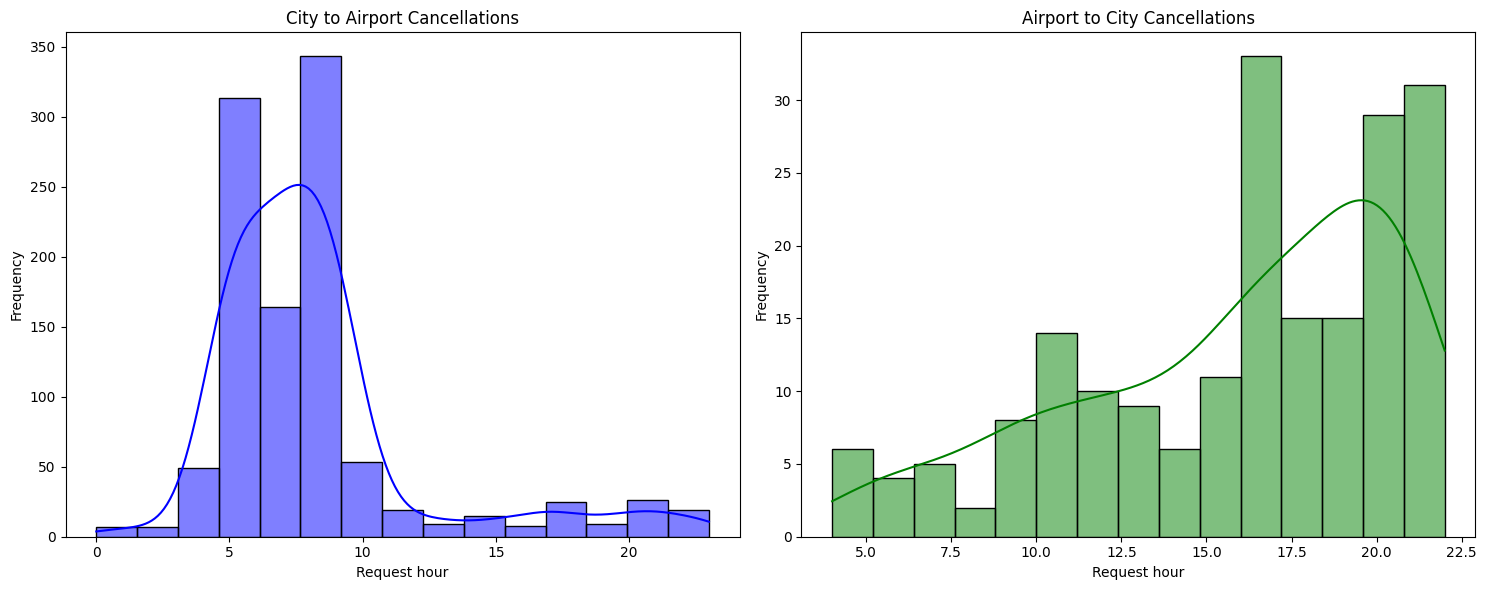

In [23]:
# Cancelled trips by request hour and location
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(cancelled_city['Request hour'], kde=True, bins=15, color='blue', edgecolor='black')
plt.title('City to Airport Cancellations')
plt.xlabel('Request hour')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(cancelled_airport['Request hour'], kde=True, bins=15, color='green', edgecolor='black')
plt.title('Airport to City Cancellations')
plt.xlabel('Request hour')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### No Cars Available Requests

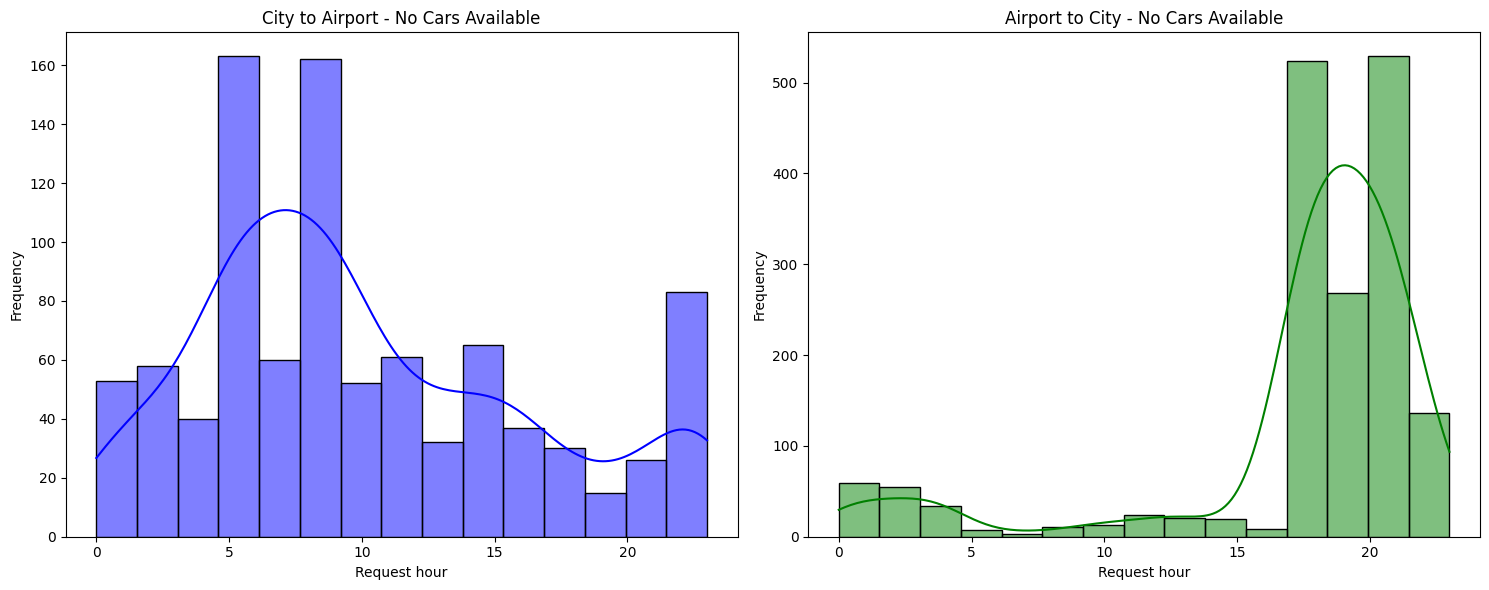

In [24]:
# 'No cars available' by request hour and location
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(no_car_city['Request hour'], kde=True, bins=15, color='blue', edgecolor='black')
plt.title('City to Airport - No Cars Available')
plt.xlabel('Request hour')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(no_car_airport['Request hour'], kde=True, bins=15, color='green', edgecolor='black')
plt.title('Airport to City - No Cars Available')
plt.xlabel('Request hour')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Trip Completed Requests

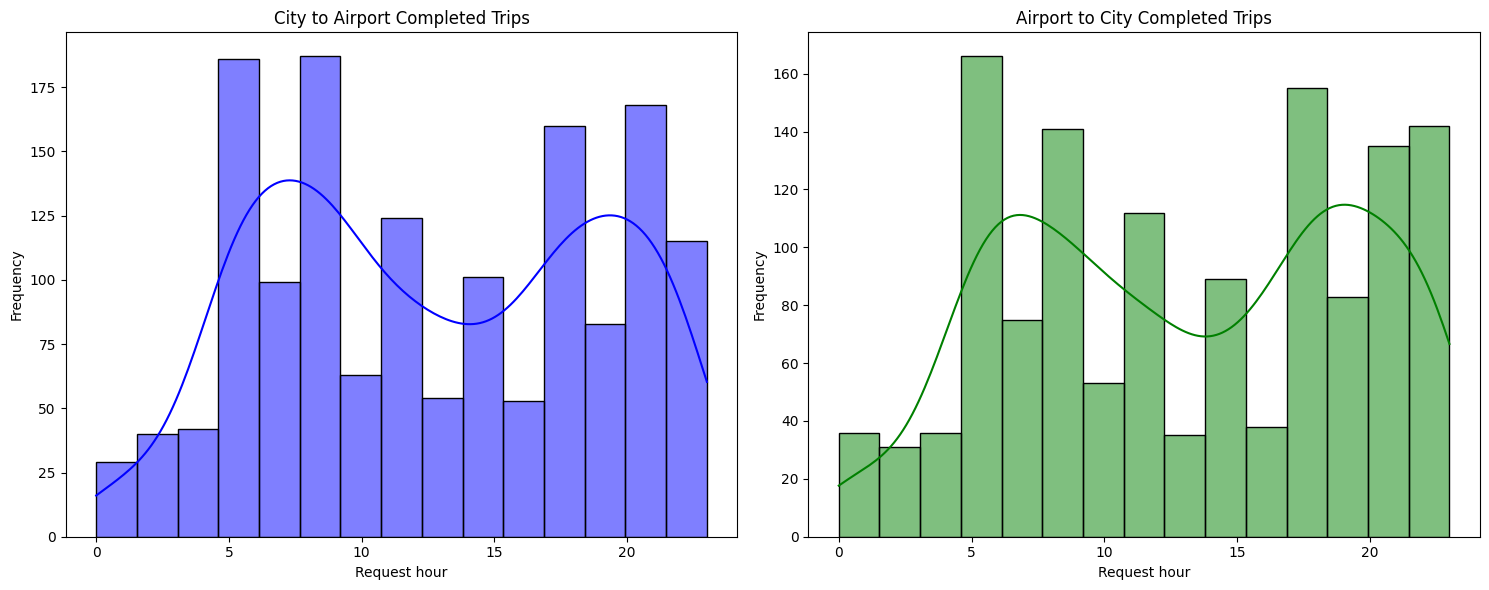

In [25]:

# Completed trips by request hour and location
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(completed_city['Request hour'], kde=True, bins=15, color='blue', edgecolor='black')
plt.title('City to Airport Completed Trips')
plt.xlabel('Request hour')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(completed_airport['Request hour'], kde=True, bins=15, color='green', edgecolor='black')
plt.title('Airport to City Completed Trips')
plt.xlabel('Request hour')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Conclusion : We should put more driver on the Airport site on evening hours to solve the no car issue. We should also check the number of driver during morning hours in the city. If it is anormally high, the companiy should relocate some to the airport during those evening hours to kill two birds with one stone.
